In [ ]:
pip install pandas_datareader

In [2]:
import math 
import pandas_datareader as web 
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential  #load_model
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [3]:

df = pd.read_csv('../input/OGEN.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-07-27,1.24,1.28,1.1300,1.180,1.180,8191900
1,2020-07-28,1.15,1.16,1.0400,1.110,1.110,5583700
2,2020-07-29,1.06,1.16,1.0400,1.120,1.120,5993300
3,2020-07-30,1.14,1.22,1.1000,1.150,1.150,8236900
4,2020-07-31,1.11,1.27,1.1100,1.210,1.210,5984600
...,...,...,...,...,...,...,...
248,2021-07-21,0.62,0.67,0.6200,0.650,0.650,2090300
249,2021-07-22,0.64,0.70,0.6200,0.660,0.660,3738300
250,2021-07-23,0.65,0.70,0.6400,0.640,0.640,2068500
251,2021-07-26,0.63,0.65,0.6100,0.630,0.630,1673200


In [4]:
# get the number of rows and columns in the data set
df.shape

(253, 7)

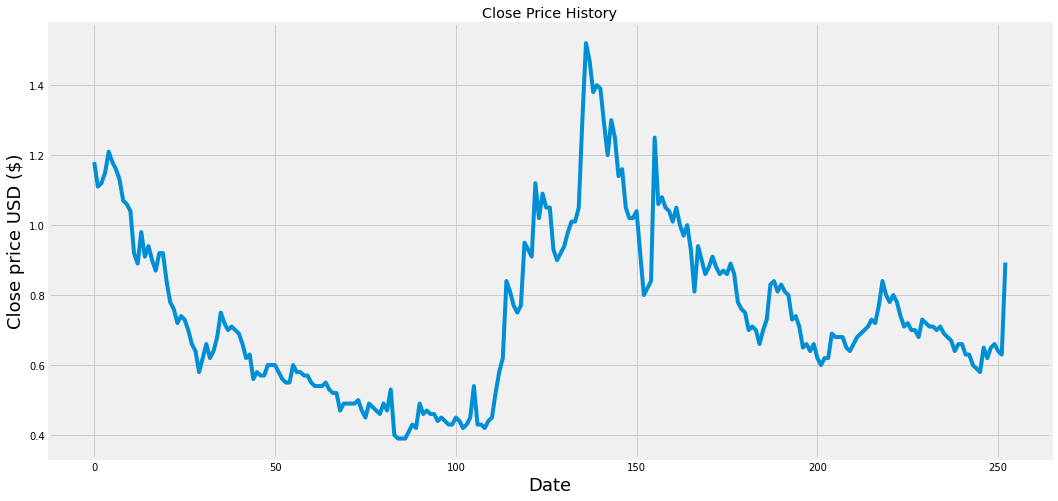

In [5]:
# visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close price USD ($)', fontsize=18)
plt.show()

In [6]:
# create a new df with only the "close" column
data = df.filter({'Close'})
# convert the df to a numpy array
dataset = data.values
# get the number of rows to train the model on
training_data_len = math.ceil(len(dataset)*.8)
training_data_len

203

In [7]:
# scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data


array([[0.69911504],
       [0.63716814],
       [0.6460177 ],
       [0.67256637],
       [0.72566372],
       [0.69911504],
       [0.68141593],
       [0.65486726],
       [0.60176991],
       [0.59292035],
       [0.57522124],
       [0.46902655],
       [0.44247788],
       [0.52212389],
       [0.46017699],
       [0.48672566],
       [0.45132743],
       [0.42477876],
       [0.46902655],
       [0.46902655],
       [0.39823009],
       [0.34513274],
       [0.32743363],
       [0.2920354 ],
       [0.30973451],
       [0.30088496],
       [0.27433628],
       [0.23893805],
       [0.22123894],
       [0.16814159],
       [0.20353982],
       [0.23893805],
       [0.20353982],
       [0.22123894],
       [0.25663717],
       [0.31858407],
       [0.2920354 ],
       [0.27433628],
       [0.28318584],
       [0.27433628],
       [0.26548673],
       [0.23893805],
       [0.20353982],
       [0.21238938],
       [0.15044248],
       [0.16814159],
       [0.15929204],
       [0.159

In [8]:
## create the training data set
# create the scaled training data set
train_data = scaled_data[0:training_data_len, :]
# split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i,0])
  y_train.append(train_data[i,0])

print(x_train)
print(y_train)

[array([0.69911504, 0.63716814, 0.6460177 , 0.67256637, 0.72566372,
       0.69911504, 0.68141593, 0.65486726, 0.60176991, 0.59292035,
       0.57522124, 0.46902655, 0.44247788, 0.52212389, 0.46017699,
       0.48672566, 0.45132743, 0.42477876, 0.46902655, 0.46902655,
       0.39823009, 0.34513274, 0.32743363, 0.2920354 , 0.30973451,
       0.30088496, 0.27433628, 0.23893805, 0.22123894, 0.16814159,
       0.20353982, 0.23893805, 0.20353982, 0.22123894, 0.25663717,
       0.31858407, 0.2920354 , 0.27433628, 0.28318584, 0.27433628,
       0.26548673, 0.23893805, 0.20353982, 0.21238938, 0.15044248,
       0.16814159, 0.15929204, 0.15929204, 0.18584071, 0.18584071,
       0.18584071, 0.16814159, 0.15044248, 0.14159292, 0.14159292,
       0.18584071, 0.16814159, 0.16814159, 0.15929204, 0.15929204]), array([0.63716814, 0.6460177 , 0.67256637, 0.72566372, 0.69911504,
       0.68141593, 0.65486726, 0.60176991, 0.59292035, 0.57522124,
       0.46902655, 0.44247788, 0.52212389, 0.46017699, 0.48

In [9]:
# convert the x_train and y_train to number arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [10]:
# reshape the data, input [samples, time steps, features] which is require for LSTM
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(143, 60, 1)

In [11]:
# build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))


In [12]:
# compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [13]:
# train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

143/143 [==============================] - 4s 15ms/step - loss: 0.0175


In [14]:
## create the testing data set
# create a new array containing scaled values from index 1543 to 2003
test_data = scaled_data[training_data_len - 60:, :]
# create the data sets x_test nad y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i,0])

In [15]:
# convert the data to a numpy array
x_test = np.array(x_test)

In [16]:
# reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))

In [17]:
# get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)


2/2 [==============================] - 1s 9ms/step


In [18]:
# get the rmse (root mean squared error)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

0.07947989911079407

C:\Users\Hiep\AppData\Local\Temp\ipykernel_17960\3363781652.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Prediction'] = predictions


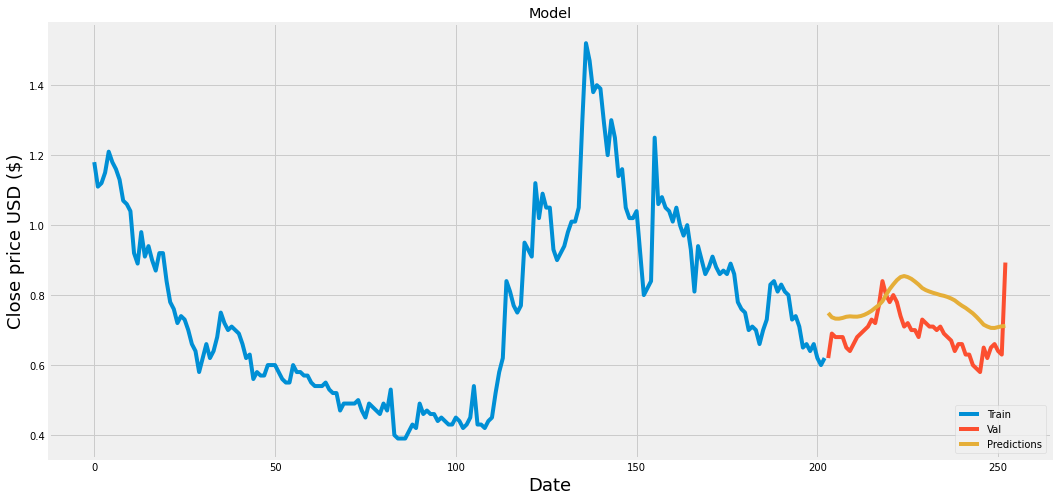

In [19]:
# plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Prediction'] = predictions
# visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Prediction']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [20]:
# show the valid and predicted prices
valid

,Close,Prediction
203,0.620,0.748716
204,0.690,0.736660
205,0.680,0.732661
206,0.680,0.732583
207,0.680,0.734750
208,0.650,0.738040
209,0.640,0.739268
210,0.660,0.738485
211,0.680,0.738309
212,0.690,0.740109


In [21]:
valid.index=pd.to_datetime(df['Date'].loc[training_data_len:].copy())
valid.to_csv('../out/LSTM/OGEN.csv')
valid

,Close,Prediction
Date,,
2021-05-17,0.620,0.748716
2021-05-18,0.690,0.736660
2021-05-19,0.680,0.732661
2021-05-20,0.680,0.732583
2021-05-21,0.680,0.734750
2021-05-24,0.650,0.738040
2021-05-25,0.640,0.739268
2021-05-26,0.660,0.738485
2021-05-27,0.680,0.738309


In [23]:
temp = df['Date'].loc[training_data_len:]
print(temp)

203    2021-05-17
204    2021-05-18
205    2021-05-19
206    2021-05-20
207    2021-05-21
208    2021-05-24
209    2021-05-25
210    2021-05-26
211    2021-05-27
212    2021-05-28
213    2021-06-01
214    2021-06-02
215    2021-06-03
216    2021-06-04
217    2021-06-07
218    2021-06-08
219    2021-06-09
220    2021-06-10
221    2021-06-11
222    2021-06-14
223    2021-06-15
224    2021-06-16
225    2021-06-17
226    2021-06-18
227    2021-06-21
228    2021-06-22
229    2021-06-23
230    2021-06-24
231    2021-06-25
232    2021-06-28
233    2021-06-29
234    2021-06-30
235    2021-07-01
236    2021-07-02
237    2021-07-06
238    2021-07-07
239    2021-07-08
240    2021-07-09
241    2021-07-12
242    2021-07-13
243    2021-07-14
244    2021-07-15
245    2021-07-16
246    2021-07-19
247    2021-07-20
248    2021-07-21
249    2021-07-22
250    2021-07-23
251    2021-07-26
252    2021-07-27
Name: Date, dtype: object
